In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import glob
from pathlib import Path
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 6)

# === USING LOCAL DATA FOLDERS ===
candidates = [
    Path("/content/drive/MyDrive/archive")
]
existing = [p for p in candidates if p.exists()]
if not existing:
    print("No local data folders found. Checked:", [str(p) for p in candidates])
else:
    print("Using data folders:", [str(p) for p in existing])

# === Collect image–mask pairs from all existing data folders ===
all_tif = []
for root in existing:
    all_tif.extend(glob.glob(str(root / "**/*.tif"), recursive=True))
all_tif = sorted(all_tif)
mask_files = [f for f in all_tif if f.endswith("_mask.tif")]
image_files = [f for f in all_tif if not f.endswith("_mask.tif")]

print("Total .tif files:", len(all_tif))
print("Images:", len(image_files))
print("Masks:", len(mask_files))

pairs = []
for img_path in image_files:
    img_path = Path(img_path)
    mask_path = img_path.with_name(img_path.stem + "_mask.tif")
    if mask_path.exists():
        pairs.append((str(img_path), str(mask_path)))

print("Valid pairs:", len(pairs))

df = pd.DataFrame(pairs, columns=["image_path", "mask_path"])
df.head()


Using data folders: ['/content/drive/MyDrive/archive']
Total .tif files: 15731
Images: 7873
Masks: 7858
Valid pairs: 7858


,image_path,mask_path
0,/content/drive/MyDrive/archive/kaggle_3m/TCGA_...,/content/drive/MyDrive/archive/kaggle_3m/TCGA_...
1,/content/drive/MyDrive/archive/kaggle_3m/TCGA_...,/content/drive/MyDrive/archive/kaggle_3m/TCGA_...
2,/content/drive/MyDrive/archive/kaggle_3m/TCGA_...,/content/drive/MyDrive/archive/kaggle_3m/TCGA_...
3,/content/drive/MyDrive/archive/kaggle_3m/TCGA_...,/content/drive/MyDrive/archive/kaggle_3m/TCGA_...
4,/content/drive/MyDrive/archive/kaggle_3m/TCGA_...,/content/drive/MyDrive/archive/kaggle_3m/TCGA_...


Number of patient folders: 220

Slices per patient (first 10):
image_path
TCGA_CS_4941_19960909    46
TCGA_CS_4942_19970222    40
TCGA_CS_4943_20000902    40
TCGA_CS_4944_20010208    40
TCGA_CS_5393_19990606    40
TCGA_CS_5395_19981004    40
TCGA_CS_5396_20010302    48
TCGA_CS_5397_20010315    44
TCGA_CS_6186_20000601    50
TCGA_CS_6188_20010812    48
Name: count, dtype: int64


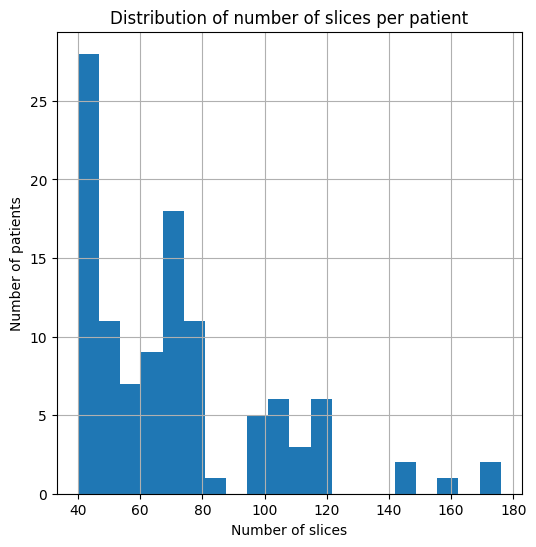

In [4]:
# Number of patients (folders) — computed from image file parent directories
patient_dirs = sorted({Path(p).parent for p in image_files})
print(f"Number of patient folders: {len(patient_dirs)}")

# Count slices per patient
slices_per_patient = (
    df["image_path"]
    .apply(lambda p: Path(p).parent.name)
    .value_counts()
    .sort_index()
)

print("\nSlices per patient (first 10):")
print(slices_per_patient.head(10))

plt.figure()
slices_per_patient.hist(bins=20)
plt.title("Distribution of number of slices per patient")
plt.xlabel("Number of slices")
plt.ylabel("Number of patients")
plt.show()


In [5]:
def get_shape(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)  # keep as stored
    return img.shape  # (H, W, C)

# Sample some files (or use all, but that’s slower)
sample_paths = df.sample(min(200, len(df)), random_state=42)

img_shapes = [get_shape(p) for p in sample_paths["image_path"]]
mask_shapes = [get_shape(p) for p in sample_paths["mask_path"]]

print("Unique image shapes in sample:", set(img_shapes))
print("Unique mask shapes in sample:", set(mask_shapes))

# If you want to check separately height/width
heights = [s[0] for s in img_shapes]
widths  = [s[1] for s in img_shapes]

print(f"Image height: mean={np.mean(heights):.1f}, min={np.min(heights)}, max={np.max(heights)}")
print(f"Image width : mean={np.mean(widths):.1f}, min={np.min(widths)}, max={np.max(widths)}")


Unique image shapes in sample: {(256, 256, 3)}
Unique mask shapes in sample: {(256, 256)}
Image height: mean=256.0, min=256, max=256
Image width : mean=256.0, min=256, max=256


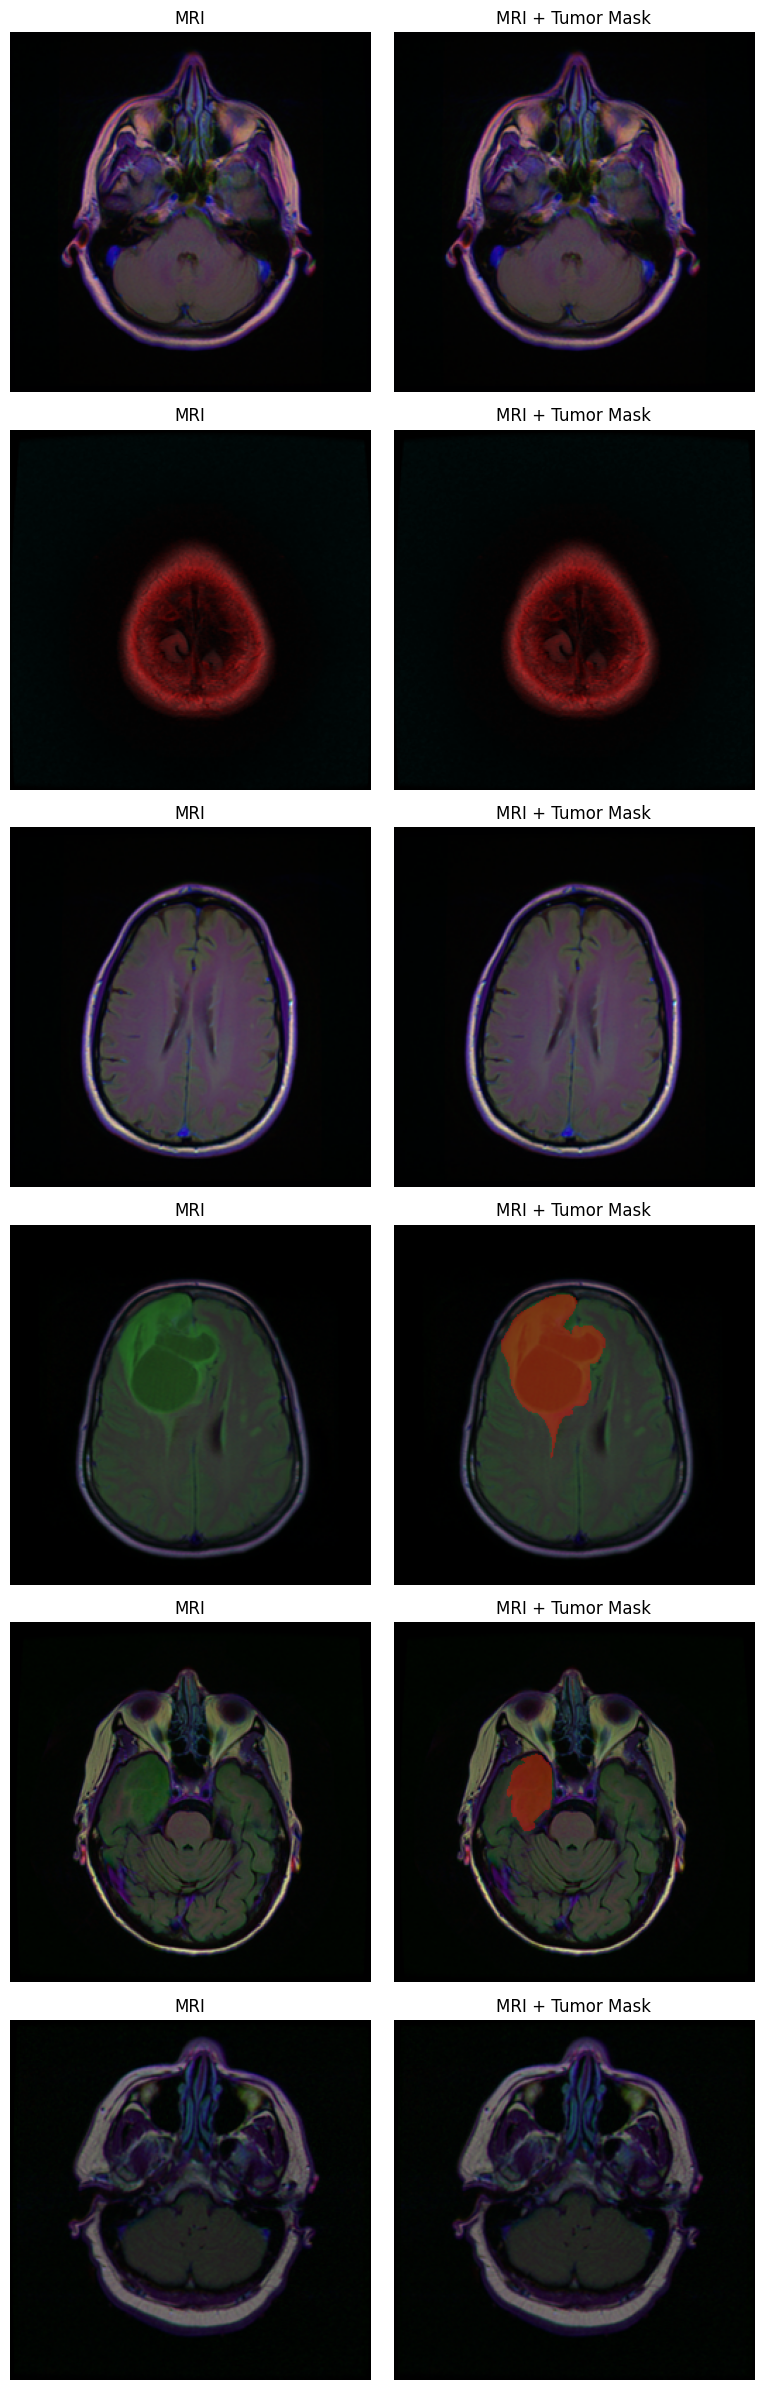

In [6]:
def show_random_examples(df, n=4):
    rows = n       # one row per example
    cols = 2       # MRI | MRI+Mask

    sample = df.sample(n, random_state=random.randint(0, 10_000))
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, row in enumerate(sample.itertuples(), 1):
        img = cv2.imread(row.image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(row.mask_path, cv2.IMREAD_GRAYSCALE)
        mask_norm = (mask > 0).astype(np.float32)

        # MRI only
        plt.subplot(rows, cols, 2*i - 1)
        plt.imshow(img)
        plt.title("MRI")
        plt.axis("off")

        # MRI + overlay
        overlay = img.copy().astype(np.float32)
        overlay[mask_norm == 1] = [255, 0, 0]
        blended = (0.6 * img + 0.4 * overlay).astype(np.uint8)

        plt.subplot(rows, cols, 2*i)
        plt.imshow(blended)
        plt.title("MRI + Tumor Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


show_random_examples(df, n=6)


Slices with tumor    : 2746
Slices without tumor : 5112


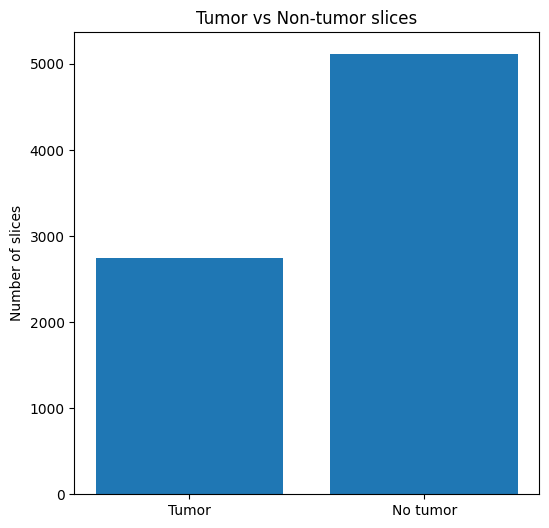

In [7]:
def has_tumor(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return int(mask.max() > 0)

df["tumor"] = df["mask_path"].apply(has_tumor)

tumor_counts = df["tumor"].value_counts().sort_index()
n_non_tumor = tumor_counts.get(0, 0)
n_tumor = tumor_counts.get(1, 0)

print(f"Slices with tumor    : {n_tumor}")
print(f"Slices without tumor : {n_non_tumor}")

plt.figure()
plt.bar(["Tumor", "No tumor"], [n_tumor, n_non_tumor])
plt.title("Tumor vs Non-tumor slices")
plt.ylabel("Number of slices")
plt.show()


In [ ]:
!pip install -q albumentations==1.4.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 4.7 MB/s eta 0:00:00


Balanced DataFrame not found. Proceeding with augmentation.
Before balancing:
  Tumor slices    : 2746
  Non-tumor slices: 5112

Need to generate 2366 augmented tumor images.


100%|██████████| 2366/2366 [07:17<00:00,  5.41it/s]



After balancing:
  Tumor slices    : 5112
  Non-tumor slices: 5112
  Total slices    : 10224
Balanced DataFrame saved to df_balanced.csv


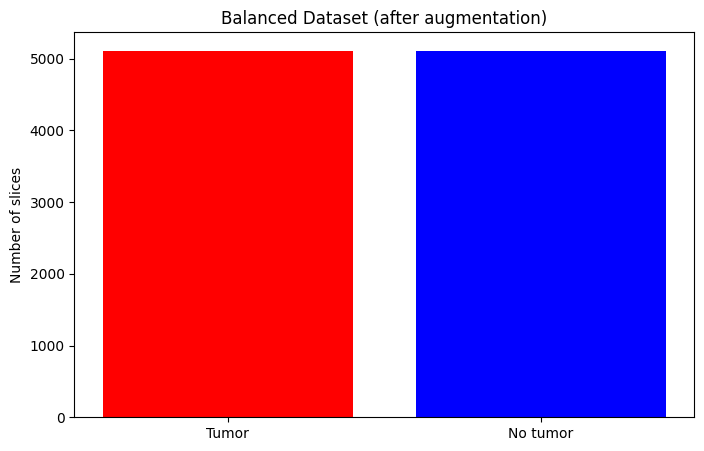

In [ ]:
import albumentations as A
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

BALANCED_DF_PATH = "df_balanced.csv"

if Path(BALANCED_DF_PATH).exists():
    print(f"Loading balanced DataFrame from {BALANCED_DF_PATH}")
    df_balanced = pd.read_csv(BALANCED_DF_PATH)
    # Ensure image_path and mask_path are correctly interpreted if needed
    print(f"  Total slices loaded: {len(df_balanced)}")
    print(f"  Tumor slices    : {(df_balanced['tumor'] == 1).sum()}")
    print(f"  Non-tumor slices: {(df_balanced['tumor'] == 0).sum()}")
else:
    print("Balanced DataFrame not found. Proceeding with augmentation.")

    # 1) SEPARATE TUMOR & NON-TUMOR
    tumor_df = df[df['tumor'] == 1].copy()
    non_tumor_df = df[df['tumor'] == 0].copy()

    print("Before balancing:")
    print(f"  Tumor slices    : {len(tumor_df)}")
    print(f"  Non-tumor slices: {len(non_tumor_df)}")

    # 2) AUGMENTATION PIPELINE
    augmentations = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.3)
    ])

    # 3) PREPARE STORAGE FOR AUGMENTED IMAGES
    aug_dir = Path("augmented_dataset")
    aug_img_dir = aug_dir / "images"
    aug_mask_dir = aug_dir / "masks"

    aug_img_dir.mkdir(parents=True, exist_ok=True)
    aug_mask_dir.mkdir(parents=True, exist_ok=True)

    # 4) HOW MANY TUMOR IMAGES DO WE NEED?
    n_needed = len(non_tumor_df) - len(tumor_df)
    print(f"\nNeed to generate {n_needed} augmented tumor images.")

    augmented_rows = []

    # 5) CREATE BALANCING AUGMENTATIONS
    for idx in tqdm(range(n_needed)):

        # SAMPLE A RANDOM TUMOR ROW
        row = tumor_df.sample(1).iloc[0]

        img_path = row["image_path"]
        mask_path = row["mask_path"]

        # LOAD ORIGINAL IMG + MASK
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # APPLY DATA AUGMENTATION
        augmented = augmentations(image=img, mask=mask)

        new_img = augmented["image"]
        new_mask = augmented["mask"]

        # SAVE TO DISK
        new_img_path = aug_img_dir / f"aug_image_{idx}.png"
        new_mask_path = aug_mask_dir / f"aug_mask_{idx}.png"

        cv2.imwrite(str(new_img_path), cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR))
        cv2.imwrite(str(new_mask_path), new_mask)

        # ADD TO DATAFRAME ROWS
        augmented_rows.append({
            "image_path": str(new_img_path),
            "mask_path": str(new_mask_path),
            "tumor": 1
        })

    # 6) BUILD FINAL BALANCED DATAFRAME
    augmented_df = pd.DataFrame(augmented_rows)

    df_balanced = pd.concat([non_tumor_df, tumor_df, augmented_df], ignore_index=True)

    print("\nAfter balancing:")
    print(f"  Tumor slices    : {(df_balanced['tumor'] == 1).sum()}")
    print(f"  Non-tumor slices: {(df_balanced['tumor'] == 0).sum()}")
    print(f"  Total slices    : {len(df_balanced)}")

    df_balanced.to_csv(BALANCED_DF_PATH, index=False)
    print(f"Balanced DataFrame saved to {BALANCED_DF_PATH}")

# 7) VISUALIZE BALANCE
plt.figure(figsize=(8, 5))
balanced_counts = df_balanced['tumor'].value_counts().sort_index()
plt.bar(["Tumor", "No tumor"],
        [balanced_counts.get(1, 0), balanced_counts.get(0, 0)],
        color=['red', 'blue'])
plt.title("Balanced Dataset (after augmentation)")
plt.ylabel("Number of slices")
plt.show()

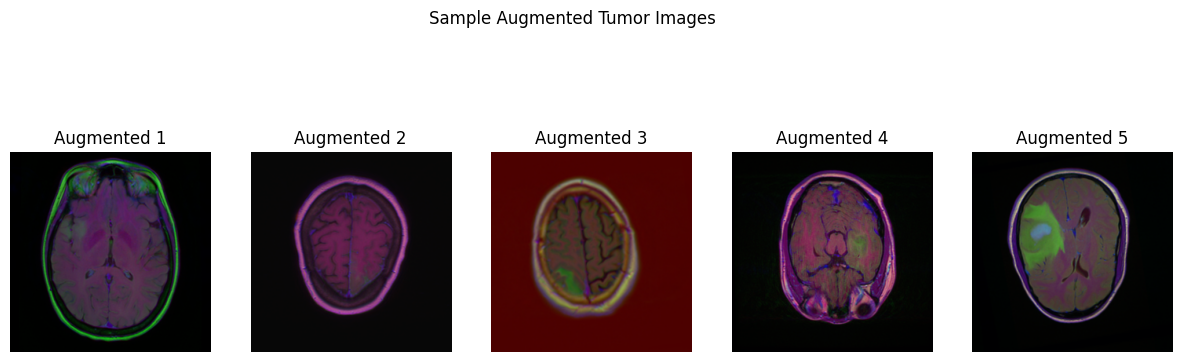

In [ ]:
# Visualize some augmented tumor images
n_display = 5
plt.figure(figsize=(15, 5))

sample_augmented_df = augmented_df.sample(n=n_display, random_state=42)

for i, row in enumerate(sample_augmented_df.itertuples()):
    img_data = cv2.imread(row.image_path)
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)

    plt.subplot(1, n_display, i + 1)
    plt.imshow(img_data)
    plt.axis('off')
    plt.title(f"Augmented {i+1}")

plt.suptitle("Sample Augmented Tumor Images")
plt.show()

In [ ]:
# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Compute split sizes
n_total = len(df_balanced)
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)
n_test  = n_total - n_train - n_val

# Split
train_df = df_balanced.iloc[:n_train]
val_df   = df_balanced.iloc[n_train:n_train+n_val]
test_df  = df_balanced.iloc[n_train+n_val:]

print("Dataset splits:")
print(f"  Training   : {len(train_df)} slices")
print(f"  Validation : {len(val_df)} slices")
print(f"  Test       : {len(test_df)} slices")

train_images = train_df['image_path'].tolist()
train_masks  = train_df['mask_path'].tolist()

val_images = val_df['image_path'].tolist()
val_masks  = val_df['mask_path'].tolist()

test_images = test_df['image_path'].tolist()
test_masks  = test_df['mask_path'].tolist()


Dataset splits:
  Training   : 8179 slices
  Validation : 1022 slices
  Test       : 1023 slices


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tqdm.keras import TqdmCallback

import numpy as np
import matplotlib.pyplot as plt
import math

print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPUs: []


In [ ]:
# SliceDataset class (image loader)

from tensorflow.keras.utils import Sequence
import cv2
import numpy as np

class SliceDataset(Sequence):
    def __init__(self, df, batch_size=32, img_size=(224, 224), shuffle=True):
        """
        df: DataFrame with columns ['image_path', 'tumor']
        """
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        # number of batches per epoch
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        # get batch indices
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_paths = self.df.iloc[batch_indices]['image_path'].values
        batch_labels = self.df.iloc[batch_indices]['tumor'].values

        X = np.zeros((len(batch_paths),
                      self.img_size[0],
                      self.img_size[1],
                      3), dtype=np.float32)
        y = np.array(batch_labels, dtype=np.float32)

        # load and preprocess images
        for i, p in enumerate(batch_paths):
            img = cv2.imread(p, cv2.IMREAD_COLOR)
            if img is None:
                img = np.zeros((self.img_size[0], self.img_size[1], 3), dtype=np.uint8)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, self.img_size)

            img = img.astype(np.float32)
            X[i] = img

        # apply ResNet preprocessing
        X = preprocess_input(X)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [ ]:
# Generators from your existing splits

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_generator = SliceDataset(train_df, batch_size=BATCH_SIZE,
                               img_size=IMG_SIZE, shuffle=True)
val_generator   = SliceDataset(val_df,   batch_size=BATCH_SIZE,
                               img_size=IMG_SIZE, shuffle=False)
test_generator  = SliceDataset(test_df,  batch_size=BATCH_SIZE,
                               img_size=IMG_SIZE, shuffle=False)

print("Batches per epoch:")
print("  train:", len(train_generator))
print("  val  :", len(val_generator))
print("  test :", len(test_generator))



Batches per epoch:
  train: 256
  val  : 32
  test : 32


In [ ]:
# Build ResNet50-based binary classifier

def build_resnet_model(input_shape=(224, 224, 3)):
    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )

    for layer in base_model.layers:
        layer.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)  # binary classification

    model = models.Model(inputs, outputs)
    return model

model = build_resnet_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", AUC(name="auc")]
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
#Callbacks

from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = "resnet_tumor_best.h5"

callbacks = [
    TqdmCallback(verbose=1),
    EarlyStopping(
        monitor="val_auc",
        patience=5,
        mode="max",
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        checkpoint_path,
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_auc",
        mode="max",
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
#Training

EPOCHS = 20

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=0
)

print("Training finished.")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_auc improved from -inf to 0.93280, saving model to resnet_tumor_best.h5



Epoch 2: val_auc improved from 0.93280 to 0.95172, saving model to resnet_tumor_best.h5



Epoch 3: val_auc improved from 0.95172 to 0.95929, saving model to resnet_tumor_best.h5



Epoch 4: val_auc improved from 0.95929 to 0.96426, saving model to resnet_tumor_best.h5



Epoch 5: val_auc improved from 0.96426 to 0.96908, saving model to resnet_tumor_best.h5



Epoch 6: val_auc improved from 0.96908 to 0.97305, saving model to resnet_tumor_best.h5



Epoch 7: val_auc improved from 0.97305 to 0.97335, saving model to resnet_tumor_best.h5



Epoch 8: val_auc improved from 0.97335 to 0.97654, saving model to resnet_tumor_best.h5



Epoch 9: val_auc improved from 0.97654 to 0.98040, saving model to resnet_tumor_best.h5



Epoch 10: val_auc improved from 0.98040 to 0.98176, saving model to resnet_tumor_best.h5



Epoch 11: val_auc improved from 0.98176 to 0.98232, saving model to resnet_tumor_best.h5



Epoch 12: val_auc improved from 0.98232 to 0.98464, saving model to resnet_tumor_best.h5



Epoch 13: val_auc improved from 0.98464 to 0.98589, saving model to resnet_tumor_best.h5



Epoch 14: val_auc improved from 0.98589 to 0.98590, saving model to resnet_tumor_best.h5



Epoch 15: val_auc improved from 0.98590 to 0.98721, saving model to resnet_tumor_best.h5



Epoch 16: val_auc did not improve from 0.98721

Epoch 17: val_auc improved from 0.98721 to 0.98799, saving model to resnet_tumor_best.h5



Epoch 18: val_auc improved from 0.98799 to 0.98852, saving model to resnet_tumor_best.h5



Epoch 19: val_auc improved from 0.98852 to 0.99068, saving model to resnet_tumor_best.h5



Epoch 20: val_auc improved from 0.99068 to 0.99103, saving model to resnet_tumor_best.h5


Restoring model weights from the end of the best epoch: 20.
Training finished.


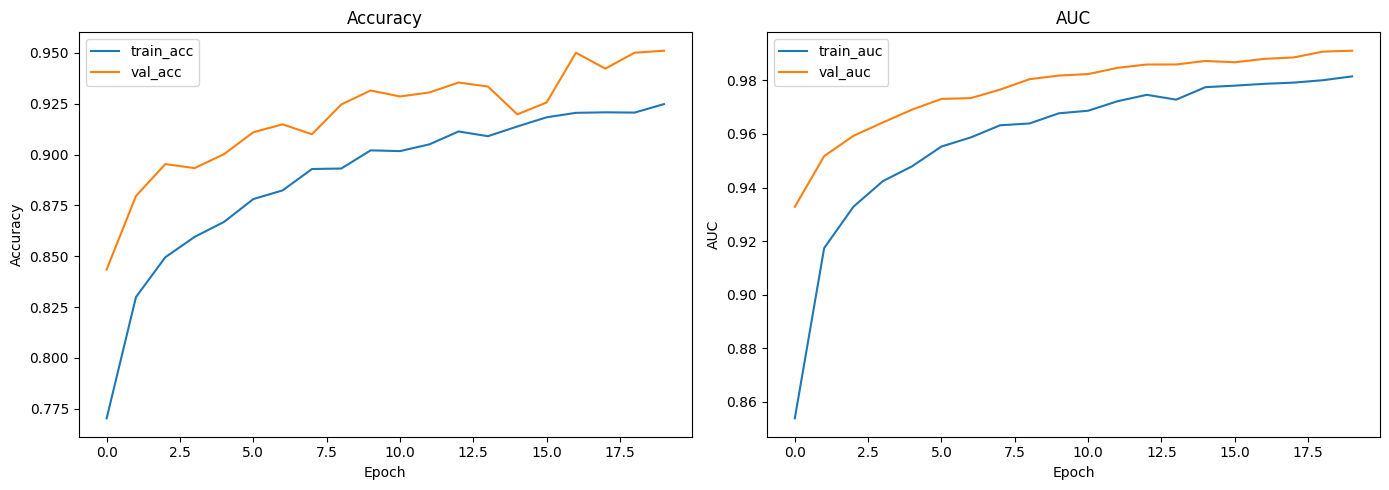

In [ ]:
# Plot training history

def plot_history(history):
    history_dict = history.history

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_dict["accuracy"], label="train_acc")
    plt.plot(history_dict["val_accuracy"], label="val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # AUC
    if "auc" in history_dict:
        plt.subplot(1, 2, 2)
        plt.plot(history_dict["auc"], label="train_auc")
        plt.plot(history_dict["val_auc"], label="val_auc")
        plt.title("AUC")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


In [ ]:
# Test evaluation

test_loss, test_acc, test_auc = model.evaluate(test_generator)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 183s 6s/step - accuracy: 0.9391 - auc: 0.9880 - loss: 0.1650
Test loss: 0.1705
Test accuracy: 0.9296
Test AUC: 0.9856


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


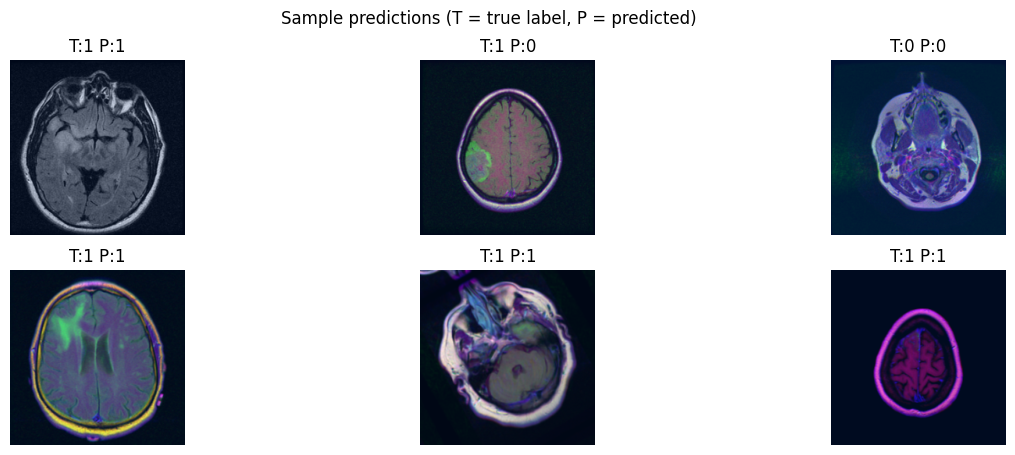

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X_batch, y_batch = test_generator[0]
y_pred_prob = model.predict(X_batch)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

n_show = min(6, len(X_batch))
plt.figure(figsize=(15, 5))

for i in range(n_show):
    plt.subplot(2, n_show // 2, i + 1)

    img = X_batch[i].copy()
    img = img[..., ::-1]
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    plt.imshow(img)
    true_label = int(y_batch[i])
    pred_label = int(y_pred[i])
    plt.title(f"T:{true_label} P:{pred_label}")
    plt.axis("off")

plt.suptitle("Sample predictions (T = true label, P = predicted)")
plt.show()


# Data Preprocessing
We used a 2D brain MRI dataset where each slice has a corresponding tumor segmentation mask. From these masks, we created a simple binary label: a slice is considered tumor (label = 1) if any pixel in the mask is non-zero, and non-tumor (label = 0) otherwise. The original dataset was imbalanced with many more non-tumor slices, so we balanced it using data augmentation on the tumor class only. We applied geometric and intensity transforms (horizontal/vertical flips, rotations, shifts, and brightness/contrast changes) with Albumentations to generate additional tumor slices. The final balanced dataset was then shuffled and split into 80% training, 10% validation, and 10% test sets

# Model
For the model, we used ResNet50 as a pretrained convolutional backbone (with ImageNet weights) and added a small classification head on top. ResNet50 is a deep residual network that uses “skip connections” to make training very deep CNNs stable and efficient. In our setup, the ResNet backbone is used as a frozen feature extractor (its weights are not updated), and we stack a Global Average Pooling layer followed by a 128-unit ReLU dense layer with 0.3 dropout and a final sigmoid output neuron for binary classification. We train this head with the Adam optimizer (learning rate 1×10⁻⁴) using binary cross-entropy loss, while monitoring both accuracy and AUC on the validation set with early stopping and model checkpointing.


# Results
The trained model achieves a test accuracy of 92.96% and a test AUC of 0.9856, which indicates excellent discrimination between tumor and non-tumor slices. In principle, we could tune the model further by adjusting the head size (number of dense units), dropout rate, learning rate, or by fine-tuning the last layers of ResNet50 with a smaller learning rate (e.g., 1×10⁻⁵). However, given that the current model already reaches very high accuracy and AUC with no obvious overfitting, additional tuning is not strictly necessary for this project and would likely result in only marginal gains

In [8]:
# now use original (imbalanced) df with class weights
df_weight = df.sample(frac=1, random_state=123).reset_index(drop=True)

n_total = len(df_weight)
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)
n_test  = n_total - n_train - n_val

train_df_w = df_weight.iloc[:n_train]
val_df_w   = df_weight.iloc[n_train:n_train + n_val]
test_df_w  = df_weight.iloc[n_train + n_val:]

print("Weighted experiment splits:")
print(f"  Training   : {len(train_df_w)}")
print(f"  Validation : {len(val_df_w)}")
print(f"  Test       : {len(test_df_w)}")

print("\nClass distribution in TRAIN (0 = no tumor, 1 = tumor):")
print(train_df_w["tumor"].value_counts())


Weighted experiment splits:
  Training   : 6286
  Validation : 785
  Test       : 787

Class distribution in TRAIN (0 = no tumor, 1 = tumor):
tumor
0    4037
1    2249
Name: count, dtype: int64


In [9]:
# Compute class weights (give more importance to tumor slices)

train_counts = train_df_w["tumor"].value_counts()
n_non_tumor = train_counts.get(0, 0)
n_tumor     = train_counts.get(1, 0)
total       = n_non_tumor + n_tumor

print(f"Train non-tumor (0): {n_non_tumor}")
print(f"Train tumor     (1): {n_tumor}")
print(f"Total train samples: {total}")

# Standard balancing formula: total / (2 * n_class)
weight_for_0 = total / (2.0 * n_non_tumor)
weight_for_1 = total / (2.0 * n_tumor)

class_weights = {0: weight_for_0, 1: weight_for_1}
print("Class weights:", class_weights)


Train non-tumor (0): 4037
Train tumor     (1): 2249
Total train samples: 6286
Class weights: {0: np.float64(0.7785484270497894), 1: np.float64(1.3975100044464206)}


In [10]:
# Generators for the weighted experiment

from tensorflow.keras.utils import Sequence
import cv2
import numpy as np
import math
from tensorflow.keras.applications.resnet50 import preprocess_input

class SliceDataset(Sequence):
    def __init__(self, df, batch_size=32, img_size=(224, 224), shuffle=True):
        """
        df: DataFrame with columns ['image_path', 'tumor']
        """
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        # number of batches per epoch
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        # get batch indices
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_paths = self.df.iloc[batch_indices]['image_path'].values
        batch_labels = self.df.iloc[batch_indices]['tumor'].values

        X = np.zeros((len(batch_paths),
                      self.img_size[0],
                      self.img_size[1],
                      3), dtype=np.float32)
        y = np.array(batch_labels, dtype=np.float32)

        # load and preprocess images
        for i, p in enumerate(batch_paths):
            img = cv2.imread(p, cv2.IMREAD_COLOR)
            if img is None:
                img = np.zeros((self.img_size[0], self.img_size[1], 3), dtype=np.uint8)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, self.img_size)

            img = img.astype(np.float32)
            X[i] = img

        # apply ResNet preprocessing
        X = preprocess_input(X)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32

train_generator_w = SliceDataset(
    train_df_w,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=True
)

val_generator_w = SliceDataset(
    val_df_w,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=False
)

test_generator_w = SliceDataset(
    test_df_w,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=False
)

print("Batches per epoch (weighted experiment):")
print("  train:", len(train_generator_w))
print("  val  :", len(val_generator_w))
print("  test :", len(test_generator_w))


Batches per epoch (weighted experiment):
  train: 197
  val  : 25
  test : 25


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

def build_resnet_model(input_shape=(224, 224, 3)):
    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )

    for layer in base_model.layers:
        layer.trainable = False

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    return model


model_w = build_resnet_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

model_w.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model_w.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
#Train with class weights (no data augmentation)
from tqdm.keras import TqdmCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = "resnet_tumor_best_weighted.h5"

callbacks = [
    TqdmCallback(verbose=1),
    EarlyStopping(
        monitor="val_auc",
        patience=5,
        mode="max",
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        checkpoint_path,
        monitor="val_auc",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_auc",
        mode="max",
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
]

EPOCHS = 20

history_w = model_w.fit(
    train_generator_w,
    validation_data=val_generator_w,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=0,
    class_weight=class_weights
)

print("Weighted training finished.")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_auc improved from -inf to 0.87944, saving model to resnet_tumor_best_weighted.h5



Epoch 2: val_auc improved from 0.87944 to 0.91159, saving model to resnet_tumor_best_weighted.h5



Epoch 3: val_auc improved from 0.91159 to 0.92652, saving model to resnet_tumor_best_weighted.h5



Epoch 4: val_auc improved from 0.92652 to 0.93744, saving model to resnet_tumor_best_weighted.h5



Epoch 5: val_auc improved from 0.93744 to 0.93806, saving model to resnet_tumor_best_weighted.h5



Epoch 6: val_auc improved from 0.93806 to 0.94685, saving model to resnet_tumor_best_weighted.h5



Epoch 7: val_auc improved from 0.94685 to 0.95498, saving model to resnet_tumor_best_weighted.h5



Epoch 8: val_auc improved from 0.95498 to 0.95513, saving model to resnet_tumor_best_weighted.h5



Epoch 9: val_auc improved from 0.95513 to 0.96047, saving model to resnet_tumor_best_weighted.h5



Epoch 10: val_auc improved from 0.96047 to 0.96091, saving model to resnet_tumor_best_weighted.h5



Epoch 11: val_auc improved from 0.96091 to 0.96406, saving model to resnet_tumor_best_weighted.h5



Epoch 12: val_auc improved from 0.96406 to 0.96535, saving model to resnet_tumor_best_weighted.h5



Epoch 13: val_auc improved from 0.96535 to 0.96569, saving model to resnet_tumor_best_weighted.h5



Epoch 14: val_auc improved from 0.96569 to 0.96924, saving model to resnet_tumor_best_weighted.h5



Epoch 15: val_auc improved from 0.96924 to 0.97441, saving model to resnet_tumor_best_weighted.h5



Epoch 16: val_auc improved from 0.97441 to 0.97473, saving model to resnet_tumor_best_weighted.h5



Epoch 17: val_auc improved from 0.97473 to 0.97691, saving model to resnet_tumor_best_weighted.h5



Epoch 18: val_auc did not improve from 0.97691

Epoch 19: val_auc improved from 0.97691 to 0.97864, saving model to resnet_tumor_best_weighted.h5



Epoch 20: val_auc improved from 0.97864 to 0.98111, saving model to resnet_tumor_best_weighted.h5


Restoring model weights from the end of the best epoch: 20.
Weighted training finished.


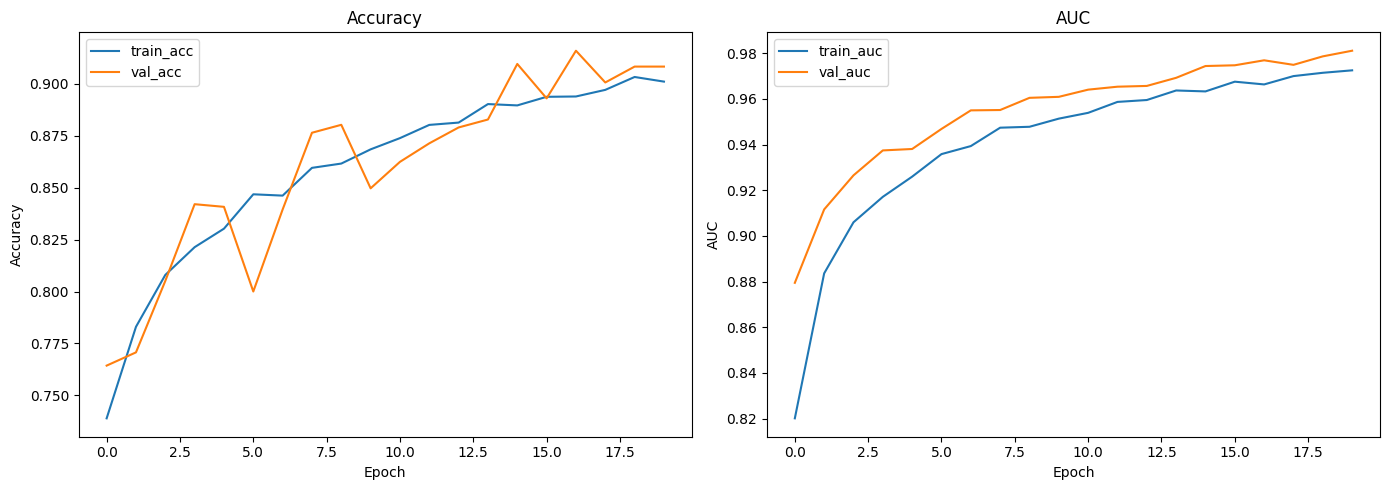

In [15]:
# Plot training history for the weighted model

import matplotlib.pyplot as plt

def plot_history(history):
    history_dict = history.history

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_dict["accuracy"], label="train_acc")
    plt.plot(history_dict["val_accuracy"], label="val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # AUC
    if "auc" in history_dict:
        plt.subplot(1, 2, 2)
        plt.plot(history_dict["auc"], label="train_auc")
        plt.plot(history_dict["val_auc"], label="val_auc")
        plt.title("AUC")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_w)

In [16]:
# Evaluate weighted model on the test set

test_loss_w, test_acc_w, test_auc_w = model_w.evaluate(test_generator_w)
print(f"[Weighted] Test loss: {test_loss_w:.4f}")
print(f"[Weighted] Test acc : {test_acc_w:.4f}")
print(f"[Weighted] Test AUC : {test_auc_w:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 545s 22s/step - accuracy: 0.9130 - auc: 0.9827 - loss: 0.2128
[Weighted] Test loss: 0.2007
[Weighted] Test acc : 0.9238
[Weighted] Test AUC : 0.9863


In [18]:
import numpy as np

all_y_true = []
all_y_pred = []

for i in range(len(test_generator_w)):
    X_batch, y_batch = test_generator_w[i]
    y_pred_prob = model_w.predict(X_batch, verbose=0)
    y_pred_batch = (y_pred_prob > 0.5).astype(int).flatten()

    all_y_true.append(y_batch)
    all_y_pred.append(y_pred_batch)

all_y_true = np.concatenate(all_y_true).astype(int)
all_y_pred = np.concatenate(all_y_pred).astype(int)

tp = np.sum((all_y_true == 1) & (all_y_pred == 1))
fp = np.sum((all_y_true == 0) & (all_y_pred == 1))
fn = np.sum((all_y_true == 1) & (all_y_pred == 0))

dice = 2 * tp / (2 * tp + fp + fn + 1e-8)
print(f"Dice score (tumor class) on test set: {dice:.4f}")


Dice score (tumor class) on test set: 0.8947


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


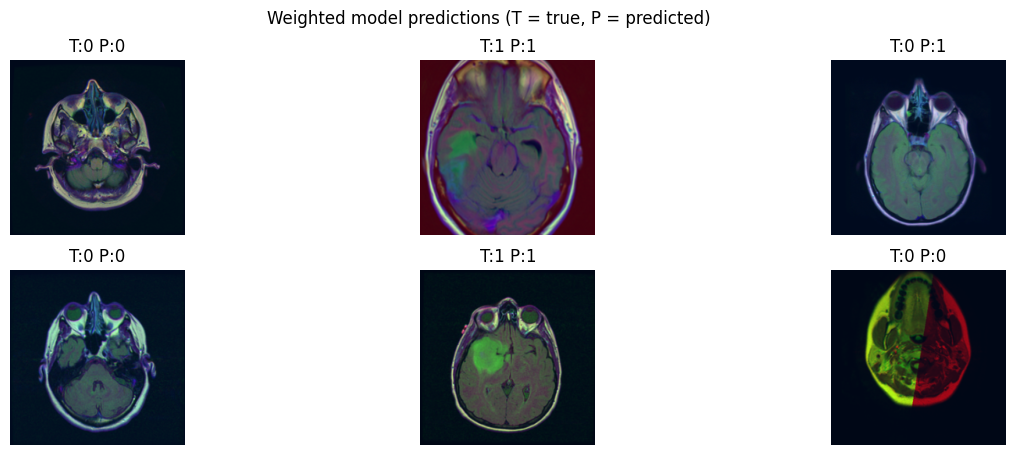

In [17]:
#Visualize some predictions of the weighted model

X_batch_w, y_batch_w = test_generator_w[0]
y_pred_prob_w = model_w.predict(X_batch_w)
y_pred_w = (y_pred_prob_w > 0.5).astype(int).flatten()

n_show = min(6, len(X_batch_w))
plt.figure(figsize=(15, 5))

for i in range(n_show):
    plt.subplot(2, n_show // 2, i + 1)

    img = X_batch_w[i].copy()
    img = img[..., ::-1]
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    plt.imshow(img)
    true_label = int(y_batch_w[i])
    pred_label = int(y_pred_w[i])
    plt.title(f"T:{true_label} P:{pred_label}")
    plt.axis("off")

plt.suptitle("Weighted model predictions (T = true, P = predicted)")
plt.show()


# Method 2: Data Preprocessing
we kept the original imbalanced dataset and handled the class imbalance during training instead of creating extra tumor images. After building the DataFrame with image paths and binary labels (tumor = 1 if the mask contains any non-zero pixel, otherwise 0), we shuffled the data and split it into 80% training, 10% validation, and 10% test. From the training set we counted how many slices belong to each class (4037 non-tumor and 2249 tumor), then converted these counts into class weights using the formula weight_for_class = total_samples / (2 × count_class). This gave a smaller weight for the majority class (non-tumor) and a larger weight for the minority class (tumor), meaning that misclassifying a tumor slice incurs a higher penalty in the loss function. During training, we passed this class_weights dictionary to model.fit, so Keras automatically scaled the binary cross-entropy loss for each sample according to its class. In this way, the model still sees the original data distribution but learns a decision boundary that pays more attention to the under-represented tumor class.

# Model Interpretation with weights
With the weighted method, we trained the same ResNet50-based classifier on the original imbalanced dataset, but gave tumor slices a higher loss weight so the model pays more attention to them. The resulting model reaches a test accuracy of about **92%** and a very high **AUC ≈ 0.986**, meaning it is excellent at separating tumor from non-tumor slices across different thresholds. The training and validation curves for both accuracy and AUC increase smoothly and stay close to each other, which shows good generalization and no serious overfitting. The sample prediction grid also confirms this: most normal slices are correctly classified as 0, and tumor slices are correctly classified as 1, indicating that weighting the classes allowed the network to handle the imbalance while still learning meaningful features from the original data.
